# R-Value Calculations for DIC Data

#### An overview of what this notebook does:

- Uses functions from previous work to load in the data from npy files
- Some of these functions were then amended to work for data that had already been loaded in (rather than having to load the data each time)
- The data is loaded in, and stress and strain (e11 and e22) values obtained
- Converted to true stress strain and Young's modulus calculated (as done in previous notebooks)
<br>
<br>R-Value specific work:
- Calculated the plastic strains and used this to calculate the R-value for each direction
- Data is cropped to between yield and UTS (as this is where true stress and strain are valid for plastic deformation)
- R-Values are plotted against strain and against time

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
def load_voltage_data(file_name: str):
    data_setrda=pd.read_csv(file_name, skiprows=1).values
    time = data_setrda[:,0] - data_setrda[0,0]
    voltage = data_setrda[:,1]
    return time, voltage

def load_instron_data(file_name: str):
    instron_setrda = pd.read_csv(file_name, skiprows=9).values
    instron_time = instron_setrda[:,0] * 1e3
    stress = instron_setrda[:,3]
    return instron_time, stress

def mask_data(stress, voltage):
    low_percentile = 5
    high_percentile = 22
    stress_mask = (int(len(stress) / 100 * low_percentile), int(len(stress) / 100 * high_percentile))
    voltage_mask = (int(len(voltage) / 100 * low_percentile), int(len(voltage) / 100 * high_percentile))
    return stress_mask, voltage_mask

def linear_regression(x, y, mask):
    gradient = linregress(x[mask[0]:mask[1]], y[mask[0]:mask[1]])
    return gradient

def get_voltage_scaling(dic_voltage_file, instron_file):    
    time, voltage = load_voltage_data(dic_voltage_file)
    instron_time, stress = load_instron_data(instron_file)
    #plot_data(time, voltage, instron_time, stress, name)
    stress_mask, voltage_mask = mask_data(stress, voltage)
    #plot_masked_data(time, voltage, voltage_mask, instron_time, stress, stress_mask)
    voltage_gradient = linear_regression(time, voltage,voltage_mask)
    stress_gradient = linear_regression(instron_time, stress, stress_mask)
    scaling_factor = stress_gradient.slope / voltage_gradient.slope
    return scaling_factor

class Deformation_map():
    def __init__(self,path,fname) :
        self.xtrim = 0
        self.ytrim = 0
        self.path = path
        self.fname = fname
        file = open(self.path+'/'+self.fname,encoding='iso-8859-1')
        self.data = np.loadtxt(file, skiprows=1, delimiter=',')
        self.xc = self.data[:,0]
        self.yc = self.data[:,1]
        self.xd = self.data[:,2]
        self.yd = self.data[:,3]
        binning_x = min(abs(np.diff(self.xc)))
        binning_y = max(abs(np.diff(self.yc)))
        assert binning_x == binning_y
        assert binning_x % 1 == 0
        self.binning = int(binning_x)      
        self.xdim = int((self.xc.max() - self.xc.min()) / binning_x) + 1
        self.ydim = int((self.yc.max() - self.yc.min()) / binning_y) + 1
        #self.x_map = self._map(self.xd)
        #self.y_map = self._map(self.yd)
        self.x_map, _ = self._map_wmissing(self.xd)
        self.y_map, _ = self._map_wmissing(self.yd)
        self.f11 = self._grad(self.x_map)[1]
        self.f22 = self._grad(self.y_map)[0]
        self.f12 = self._grad(self.x_map)[0]
        self.f21 = self._grad(self.y_map)[1]
        self.max_shear = np.sqrt((((self.f11-self.f22)/2.)**2) + ((self.f12+self.f21)/2.)**2)
        self.max_shear = self.max_shear[self.ytrim:-self.ytrim,self.xtrim:-self.xtrim]
        self.mapshape = np.shape(self.max_shear)
    def _map(self,data_col,ydim,xdim):
        data_map=np.reshape(np.array(data_col),(int(ydim),int(xdim)))
        return data_map
    def _map_wmissing(self, data_col):
        data_map = np.full((self.ydim, self.xdim), np.nan)
        xc = self.xc - self.xc.min()
        yc = self.yc - self.yc.min()
        locs = []
        for val, x, y in zip(data_col, xc, yc):
            loc = tuple(int(d / self.binning) for d in (x, y))
            if loc in locs:
                print("Multiple data values for 1 point.")
            else:
                locs.append(loc)
            data_map[loc[1], loc[0]] = val
        return data_map, locs
    def _grad(self,data_map) :
        grad_step=min(abs((np.diff(self.xc))))
        data_grad=np.gradient(data_map,grad_step,grad_step)
        return data_grad

def average_strains(sequence,roi):
    yStart=roi[0]
    yEnd=roi[1]
    xStart=roi[2]
    xEnd=roi[3]
    e11=np.empty(np.size(sequence))
    e22=np.empty(np.size(sequence))
    for k,data in enumerate(sequence):
        e11[k]=np.log(np.mean(data.f22[yStart:yEnd,xStart:xEnd].ravel())+1)
        e22[k]=np.log(np.mean(data.f11[yStart:yEnd,xStart:xEnd].ravel())+1)
    return e11,e22

def load_macro_dic(ROI,deformation_sequence, instron_file, voltage_file):
    deformation_maps = np.load(deformation_sequence, allow_pickle=True)
    voltage_scaling = get_voltage_scaling(voltage_file, instron_file)
    time, voltage = load_voltage_data(voltage_file)
    stress_data = voltage*voltage_scaling
    strain_1, strain_2 = average_strains(deformation_maps, roi = ROI)
    average_strain_data=[strain_1, strain_2]
    return deformation_maps, stress_data, average_strain_data

In [3]:
RD_A_npz = np.load('../Data/DIC/npz_files/RD_Timet_A.npz', allow_pickle=True)['arr_0']
RD_B_npz = np.load('../Data/DIC/npz_files/RD_Timet_B.npz', allow_pickle=True)['arr_0']
TD_A_npz = np.load('../Data/DIC/npz_files/TD_Timet_A.npz', allow_pickle=True)['arr_0']
TD_B_npz = np.load('../Data/DIC/npz_files/TD_Timet_B.npz', allow_pickle=True)['arr_0']
FFD_A_npz = np.load('../Data/DIC/npz_files/45degree_Timet_A.npz', allow_pickle=True)['arr_0']
FFD_B_npz = np.load('../Data/DIC/npz_files/45degree_Timet_B.npz', allow_pickle=True)['arr_0']

In [4]:
RD_A_Time, RD_A_Voltage = load_voltage_data('../Data/DIC/Voltage/RD_Timet_A_Voltage.csv')
RD_B_Time, RD_B_Voltage = load_voltage_data('../Data/DIC/Voltage/RD_Timet_B_Voltage.csv')
TD_A_Time, TD_A_Voltage = load_voltage_data('../Data/DIC/Voltage/TD_Timet_A_Voltage.csv')
TD_B_Time, TD_B_Voltage = load_voltage_data('../Data/DIC/Voltage/TD_Timet_B_Voltage.csv')
FFD_A_Time, FFD_A_Voltage = load_voltage_data('../Data/DIC/Voltage/45degree_Timet_A_Voltage.csv')
FFD_B_Time, FFD_B_Voltage = load_voltage_data('../Data/DIC/Voltage/45degree_Timet_B_Voltage.csv')

In [5]:
RD_A_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/RD_Timet_A_Voltage.csv','../Data/Instron/RD_Timet_A.csv')
RD_B_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/RD_Timet_B_Voltage.csv','../Data/Instron/RD_Timet_B.csv')
TD_A_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/TD_Timet_A_Voltage.csv','../Data/Instron/TD_Timet_A.csv')
TD_B_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/TD_Timet_B_Voltage.csv','../Data/Instron/TD_Timet_B.csv')
FFD_A_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/45degree_Timet_A_Voltage.csv','../Data/Instron/45degree_Timet_A.csv')
FFD_B_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/45degree_Timet_B_Voltage.csv','../Data/Instron/45degree_Timet_B.csv')

In [6]:
def load_DIC(ROI,npz_data,voltage_data,voltage_scaling):
    deformation_maps = npz_data
    stress_data = voltage_data*voltage_scaling
    strain_1, strain_2 = average_strains(npz_data, roi = ROI)
    average_strain_data=[strain_1, strain_2]
    return deformation_maps, stress_data, average_strain_data

In [7]:
defmap,RD_A_Stress_data,RD_A_Strain_data = load_DIC((31,59,0,28),RD_A_npz,RD_A_Voltage,RD_A_Voltage_Scaling)
defmap,RD_B_Stress_data,RD_B_Strain_data = load_DIC((57,85,0,28),RD_B_npz[:-1],RD_B_Voltage,RD_B_Voltage_Scaling)
defmap,TD_A_Stress_data,TD_A_Strain_data = load_DIC((90,118,0,28),TD_A_npz[:-1],TD_A_Voltage,TD_A_Voltage_Scaling)
defmap,TD_B_Stress_data,TD_B_Strain_data = load_DIC((102,130,0,28),TD_B_npz[:-1],TD_B_Voltage,TD_B_Voltage_Scaling)
defmap,FFD_A_Stress_data,FFD_A_Strain_data = load_DIC((90,118,0,28),FFD_A_npz[:-1],FFD_A_Voltage,FFD_A_Voltage_Scaling)
defmap,FFD_B_Stress_data,FFD_B_Strain_data = load_DIC((90,118,0,28),FFD_B_npz[:-1],FFD_B_Voltage,FFD_B_Voltage_Scaling)

RD_A_Stress = RD_A_Stress_data[0:1124]
RD_B_Stress = RD_B_Stress_data[0:1191]
TD_A_Stress = TD_A_Stress_data[0:1308]
TD_B_Stress = TD_B_Stress_data[0:1303]
FFD_A_Stress = FFD_A_Stress_data[0:1513]
FFD_B_Stress = FFD_B_Stress_data[0:1475]

RD_A_e11 = RD_A_Strain_data[0][0:1124]
RD_B_e11 = RD_B_Strain_data[0][0:1191]
TD_A_e11 = TD_A_Strain_data[0][0:1308]
TD_B_e11 = TD_B_Strain_data[0][0:1303]
FFD_A_e11 = FFD_A_Strain_data[0][0:1513]
FFD_B_e11 = FFD_B_Strain_data[0][0:1475]

RD_A_e22 = RD_A_Strain_data[1][0:1124]
RD_B_e22 = RD_B_Strain_data[1][0:1191]
TD_A_e22 = TD_A_Strain_data[1][0:1308]
TD_B_e22 = TD_B_Strain_data[1][0:1303]
FFD_A_e22 = FFD_A_Strain_data[1][0:1513]
FFD_B_e22 = FFD_B_Strain_data[1][0:1475]

### Converting this to True Stress-Strain

In [8]:
def true_stress(stress,strain):
    return stress*(1+(strain))
def true_strain(strain):
    return (np.log(1+(strain)))

RD_A_True_Stress = true_stress(RD_A_Stress,RD_A_e11)
RD_B_True_Stress = true_stress(RD_B_Stress,RD_B_e11)
TD_A_True_Stress = true_stress(TD_A_Stress,TD_A_e11)
TD_B_True_Stress = true_stress(TD_B_Stress,TD_B_e11)
FFD_A_True_Stress = true_stress(FFD_A_Stress,FFD_A_e11)
FFD_B_True_Stress = true_stress(FFD_B_Stress,FFD_B_e11)

RD_A_True_e11 = true_strain(RD_A_e11)
RD_B_True_e11 = true_strain(RD_B_e11)
TD_A_True_e11 = true_strain(TD_A_e11)
TD_B_True_e11 = true_strain(TD_B_e11)
FFD_A_True_e11 = true_strain(FFD_A_e11)
FFD_B_True_e11 = true_strain(FFD_B_e11)

RD_A_True_e22 = true_strain(RD_A_e22)
RD_B_True_e22 = true_strain(RD_B_e22)
TD_A_True_e22 = true_strain(TD_A_e22)
TD_B_True_e22 = true_strain(TD_B_e22)
FFD_A_True_e22 = true_strain(FFD_A_e22)
FFD_B_True_e22 = true_strain(FFD_B_e22)

### Calculating the Young's Moduli

In [9]:
def youngs_modulus(e,m):
    return m*e

def find_m(strain,stress):
    e = (strain)[50:300]
    S = (stress)[50:300] 
    popt, pcov = curve_fit(youngs_modulus, e, S)
    return popt[0]

RD_A_m = find_m(RD_A_True_e11,RD_A_True_Stress)
RD_B_m = find_m(RD_B_True_e11,RD_B_True_Stress)
TD_A_m = find_m(TD_A_True_e11,TD_A_True_Stress)
TD_B_m = find_m(TD_B_True_e11,TD_B_True_Stress)
FFD_A_m = find_m(FFD_A_True_e11,FFD_A_True_Stress)
FFD_B_m = find_m(FFD_B_True_e11,FFD_B_True_Stress)

v=0.34

#### Note: everything up to here is from previous notebooks, with the exception of reading in the e22 data, calculating the true strain of this, and defining poissons ratio as 0.34

In [10]:
#This calculates the plastic strain for e11 and e22 using 2 different equations (reference Magnesium paper)
def plastic_e11(true_e11,true_stress,m):
    return true_e11 - true_stress/m
    
def plastic_e22(true_e22,true_stress,m):
    return true_e22 + v*(true_stress/m)

#The plastic strain is then defined for all samples
RD_A_Plastic_e11 = plastic_e11(RD_A_True_e11,RD_A_True_Stress,RD_A_m)
RD_A_Plastic_e22 = plastic_e22(RD_A_True_e22,RD_A_True_Stress,RD_A_m)
RD_B_Plastic_e11 = plastic_e11(RD_B_True_e11,RD_B_True_Stress,RD_B_m)
RD_B_Plastic_e22 = plastic_e22(RD_B_True_e22,RD_B_True_Stress,RD_B_m)

TD_A_Plastic_e11 = plastic_e11(TD_A_True_e11,TD_A_True_Stress,TD_A_m)
TD_A_Plastic_e22 = plastic_e22(TD_A_True_e22,TD_A_True_Stress,TD_A_m)
TD_B_Plastic_e11 = plastic_e11(TD_B_True_e11,TD_B_True_Stress,TD_B_m)
TD_B_Plastic_e22 = plastic_e22(TD_B_True_e22,TD_B_True_Stress,TD_B_m)

FFD_A_Plastic_e11 = plastic_e11(FFD_A_True_e11,FFD_A_True_Stress,FFD_A_m)
FFD_A_Plastic_e22 = plastic_e22(FFD_A_True_e22,FFD_A_True_Stress,FFD_A_m)
FFD_B_Plastic_e11 = plastic_e11(FFD_B_True_e11,FFD_B_True_Stress,FFD_B_m)
FFD_B_Plastic_e22 = plastic_e22(FFD_B_True_e22,FFD_B_True_Stress,FFD_B_m)

In [11]:
#Defining a function for calculating the R value from e11 and e22 (rearranged as in written notes)

def R_val(e11,e22):
    return e22/(-e11-e22)

In [12]:
#Calculates R value for each direction

RD_A_Rval = R_val(RD_A_Plastic_e11,RD_A_Plastic_e22)
RD_B_Rval = R_val(RD_B_Plastic_e11,RD_B_Plastic_e22)
TD_A_Rval = R_val(TD_A_Plastic_e11,TD_A_Plastic_e22)
TD_B_Rval = R_val(TD_B_Plastic_e11,TD_B_Plastic_e22)
FFD_A_Rval = R_val(FFD_A_Plastic_e11,FFD_A_Plastic_e22)
FFD_B_Rval = R_val(FFD_B_Plastic_e11,FFD_B_Plastic_e22)

In [13]:
#Cropping the above data to between yield and UTS

def find_crops(true_e11,stress,true_stress,m):
    proof = true_stress/m + 0.002
    low_crop = np.argmax(np.greater(true_e11,proof)==True)
    high_crop = np.where(np.max(stress)==stress)[0][0]
    return low_crop, high_crop
    
RD_A_low,RD_A_high = find_crops(RD_A_True_e11,RD_A_Stress,RD_A_True_Stress,RD_A_m)
RD_B_low,RD_B_high = find_crops(RD_B_True_e11,RD_B_Stress,RD_B_True_Stress,RD_B_m)
TD_A_low,TD_A_high = find_crops(TD_A_True_e11,TD_A_Stress,TD_A_True_Stress,TD_A_m)
TD_B_low,TD_B_high = find_crops(TD_B_True_e11,TD_B_Stress,TD_B_True_Stress,TD_B_m)
FFD_A_low,FFD_A_high = find_crops(FFD_A_True_e11,FFD_A_Stress,FFD_A_True_Stress,FFD_A_m)
FFD_B_low,FFD_B_high = find_crops(FFD_B_True_e11,FFD_B_Stress,FFD_B_True_Stress,FFD_B_m)

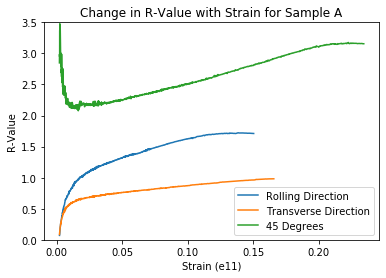

In [15]:
#Plottinng R Value against e11 strain for Sample A
#This is cropped from yield onwards

plt.plot(RD_A_Plastic_e11[RD_A_low:],RD_A_Rval[RD_A_low:],label='Rolling Direction')
plt.plot(TD_A_Plastic_e11[TD_A_low:],TD_A_Rval[TD_A_low:],label='Transverse Direction')
plt.plot(FFD_A_Plastic_e11[FFD_A_low:],FFD_A_Rval[FFD_A_low:],label='45 Degrees')
plt.xlabel('Strain (e11)')
plt.ylabel('R-Value')
plt.title('Change in R-Value with Strain for Sample A')
plt.legend(loc='best')
plt.ylim(0,3.5)
plt.savefig('Sample_A_R_Val_With_Strain.png');

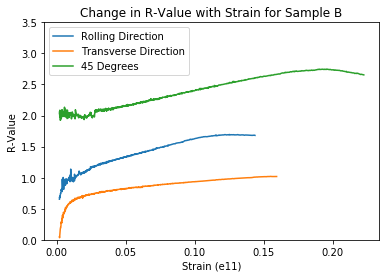

In [16]:
#Plottinng R Value against e11 strain for Sample B
#This is cropped from yield onwards

plt.plot(RD_B_Plastic_e11[RD_B_low:],RD_B_Rval[RD_B_low:],label='Rolling Direction')
plt.plot(TD_B_Plastic_e11[TD_B_low:],TD_B_Rval[TD_B_low:],label='Transverse Direction')
plt.plot(FFD_B_Plastic_e11[FFD_B_low:],FFD_B_Rval[FFD_B_low:],label='45 Degrees')
plt.xlabel('Strain (e11)')
plt.ylabel('R-Value')
plt.title('Change in R-Value with Strain for Sample B')
plt.legend(loc='best')
plt.ylim(0,3.5)
plt.savefig('Sample_B_R_Val_With_Strain.png');

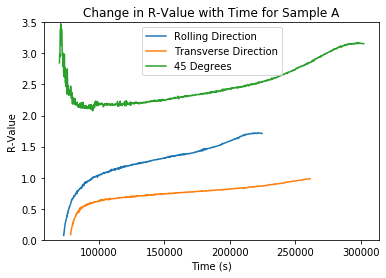

In [17]:
#We can also plot how R-Value changes with time
#Plottinng R Value against time for Sample A
#This is cropped from yield onwards

plt.plot(RD_A_Time[RD_A_low:1124],RD_A_Rval[RD_A_low:],label='Rolling Direction')
plt.plot(TD_A_Time[TD_A_low:1308],TD_A_Rval[TD_A_low:],label='Transverse Direction')
plt.plot(FFD_A_Time[FFD_A_low:1513],FFD_A_Rval[FFD_A_low:],label='45 Degrees')
plt.xlabel('Time (s)')
plt.ylabel('R-Value')
plt.title('Change in R-Value with Time for Sample A')
plt.legend(loc='best')
plt.ylim(0,3.5)
plt.savefig('Sample_A_R_Val_With_Time.png');

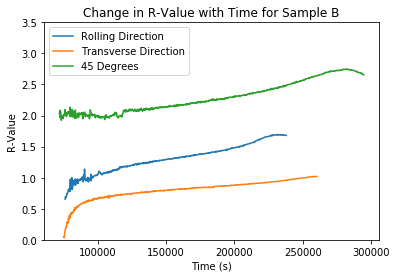

In [18]:
#Plottinng R Value against time for Sample B
#This is cropped from yield onwards

plt.plot(RD_B_Time[RD_B_low:1191],RD_B_Rval[RD_B_low:],label='Rolling Direction')
plt.plot(TD_B_Time[TD_B_low:1303],TD_B_Rval[TD_B_low:],label='Transverse Direction')
plt.plot(FFD_B_Time[FFD_B_low:1475],FFD_B_Rval[FFD_B_low:],label='45 Degrees')
plt.xlabel('Time (s)')
plt.ylabel('R-Value')
plt.title('Change in R-Value with Time for Sample B')
plt.legend(loc='best')
plt.ylim(0,3.5)
plt.savefig('Sample_B_R_Val_With_Time.png');

In [ ]:
#Note all the above graphs are cropped until after the yield point, as before this the graphs were very messy
#These are not cropped at UTS, as this gave an issue for the 45 degree samples as they went down after yield
#Although the graphs are not technically valid after yield, the trends do not change much after this point
#And so the trends can still be gained from the graph